**proyecto**
# Análisis de Videojuegos con sus ventas y calificaciones
## Diplomado Ciencia de Datos - modulo III  
  
  
  
  
**Profesor: José Gustavo Fuentes Cabrera**  
**Hernández González Ricardo Paramont**  

**DataSet**: Video_Games_Sales_as_at_22_Dec_2016.csv    
    
**************

## Dependencias

In [1]:
import numpy as np
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold

from varclushi import VarClusHi

from scipy.stats import chisquare
from scipy.stats import kruskal
from statsmodels.stats.multicomp import MultiComparison

from itertools import chain
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

cf.go_offline()
pd.set_option('display.max_columns',None)

***

***
# <p style="text-align: center;">Procesamiento de Datos</p>



***

***

## Campos de información

**Name**: Nombre del videojuego.  
**Platform**: Consola de videojuegos.  
**Year of release**: Año de publicación del videojuego.  
**Genre**: Género del videojuego.  
**Publisher**: Empresa que publica el videojuego.  
**NA_sales**: Ventas en undades en Norteamérica.  
**EU_sales**: Ventas en unidades en Europa.  
**JP_sales**: Ventas en unidades en Japón.  
**Other_sales**: Ventas en otras partes del mundo.  
**Gloal_sales**: Ventas mundiales totales.  
**Critic_score**: Calificación agregada compilada por Metacritic.  
**Critic_count**: Número de críticas usadas para el valor de Critic_Score.  
**User_score**: Calificación dada por usuarios de Metacritic.  
**User_count**: Número de criticas usadas para el valor de User_score.  
**Developer**: Empresa desarrolladora del videojuego.  
**Rating**: Rating según ESRB.

## Lectura de Datos

In [2]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
print(f'Tamaño del dataset: {df.shape}')
df.head()

Tamaño del dataset: (6811, 16)


,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


## Definición de variables 

In [3]:
varc = ['year_of_release','na_sales','eu_sales','jp_sales','other_sales','global_sales',
       'critic_score','critic_count','user_score','user_count']
vard = ['platform','genre','publisher','rating','name','developer']

## Completitud

In [4]:
def completitud(df):
    comp=pd.DataFrame(df.isnull().sum())
    comp.reset_index(inplace=True)
    comp=comp.rename(columns={"index":"columna",0:"total"})
    comp["completitud"]=round((1-comp["total"]/df.shape[0])*100, 3)
    comp=comp.sort_values(by="completitud",ascending=True)
    comp.reset_index(drop=True,inplace=True)
    return comp

In [5]:
completitud(df)

,columna,total,completitud
0,name,0,100.0
1,platform,0,100.0
2,year_of_release,0,100.0
3,genre,0,100.0
4,publisher,0,100.0
5,na_sales,0,100.0
6,eu_sales,0,100.0
7,jp_sales,0,100.0
8,other_sales,0,100.0
9,global_sales,0,100.0


Afortunadamente, todas las columnas cuentas con registros completos.

## Duplicados

In [6]:
df.duplicated().sum()

0

No hay duplicados.

## Análisis Exploratorio

### Continuas

In [7]:
df[varc].describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count
count,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000
mean,2007.451916,0.395068,0.236532,0.063900,0.082838,0.778520,70.236970,28.954339,7.182866,174.907796
std,4.202178,0.968207,0.687961,0.287742,0.270124,1.965288,13.858778,19.235502,1.439574,588.005932
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,6.500000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,7.500000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,8.200000,88.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,9.600000,10665.000000


Se confirma que todas las variables contienen valores dentro de rangos esperados, según el valor min y max.

#### Distribuciones

In [8]:
varc

['year_of_release',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'global_sales',
 'critic_score',
 'critic_count',
 'user_score',
 'user_count']

<AxesSubplot:>

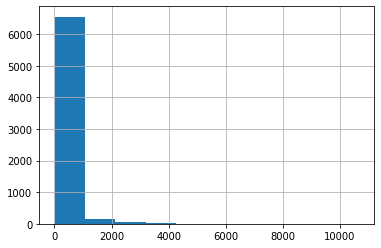

In [9]:
df['user_count'].hist()

### Categóricas

In [10]:
df[vard].describe()

,platform,genre,publisher,rating,name,developer
count,6811,6811,6811,6811,6811,6811
unique,16,12,262,7,4365,1289
top,PS2,Action,Electronic Arts,T,LEGO Star Wars II: The Original Trilogy,EA Canada
freq,1140,1630,944,2367,8,149


Por el número de valores únicos, no se considerarán:
* name
* developer

#### Frecuencia

In [11]:
def my_pie_count(df,col,title=""):
    aux=pd.DataFrame(df[col].value_counts()).reset_index().rename(columns={"index":"conteo"})
    fig=aux.iplot(kind='pie',labels='conteo',values=col,title=title,asFigure=True,theme="white")
    return fig

In [12]:
for v in vard[:-2]:
    display(my_pie_count(df,v,v))

##### Normalización

In [13]:
def normalizar(df,v,umbral=0.05):
    aux = df[v].value_counts(1).to_frame().reset_index()
    aux['mapa'] = np.where(aux[v]<umbral,'OTROS',aux['index'])
    mas_grande = aux.head(1)['index'].values[0]
    if aux.loc[aux['mapa']=='OTROS'][v].sum()<umbral:
        aux['mapa'] = aux['mapa'].replace({'OTROS':mas_grande})
    return v,dict(aux[['index','mapa']].values.tolist())

In [14]:
mapa_norm = list(map(lambda v:normalizar(df,v),vard[:-2]))

In [15]:
for v,d in mapa_norm:
    df[f'n_{v}'] = df[v].replace(d)

In [16]:
varn = df.filter(like='n_').columns.tolist()

In [17]:
df[varn].describe()

,n_platform,n_genre,n_publisher,n_rating
count,6811,6811,6811,6811
unique,10,9,4,4
top,OTROS,Action,OTROS,T
freq,1147,1630,4880,2370


## Extremos

In [18]:
#Buscando extremos segun percentiles 1 y 99
for v,li,ls in df[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    df[f'ex_{v}'] = ((df[v]<li)|(df[v]>ls)).astype(int)
df['ex_'] = df.filter(like='ex_').max(axis=1)

In [19]:
df['ex_'].value_counts(True)
#1 significa que es valor extremo

0    0.933196
1    0.066804
Name: ex_, dtype: float64

In [20]:
#Borrando extremos
df = df.loc[df['ex_']==0].reset_index(drop=True).drop(df.filter(like='ex_').columns,axis=1)

## Varianza Baja

In [21]:
vt = VarianceThreshold(threshold=0.1)
vt.fit(df[varc])

VarianceThreshold(threshold=0.1)

In [22]:
varianza_peq = [v for v,nu in zip(varc,vt.get_support()) if not nu]
varianza_peq

['eu_sales', 'jp_sales', 'other_sales']

In [23]:
varc = [v for v in varc if v not in varianza_peq]
df.drop(varianza_peq,axis=1,inplace=True)

## Multicolinealidad

In [24]:
vc = VarClusHi(df=df,feat_list=varc)
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
rs

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,na_sales,0.957161,0.097049,4.744313e-02,1
1,0,global_sales,0.957161,0.148158,5.028961e-02,2
2,1,user_score,0.766536,0.068925,2.507463e-01,1
3,1,critic_score,0.766536,0.157168,2.769989e-01,2
4,2,user_count,0.686188,0.084277,3.426927e-01,1
5,2,critic_count,0.686188,0.113745,3.540874e-01,2
6,3,year_of_release,1.000000,0.078028,2.408365e-16,1


Se observa que se tienen realmente sólo cuatro dimensiones:
* Las ventas
* Las calificaciones
* El número de críticas dadas
* El año de publicación 

In [25]:
var_reduced = sorted(rs.loc[rs['id']==1]['Variable'])

In [26]:
var_reduced

['na_sales', 'user_count', 'user_score', 'year_of_release']

## Correlación

In [27]:
#Todas la continuas
df[varc].corr().iplot(kind="heatmap",colorscale='spectral')

In [28]:
#Variables que no tienen multicolinealidad
df[var_reduced].corr().iplot(kind="heatmap",colorscale='spectral')

***

***
# <p style="text-align: center;">Previzualización en Espacio Reducido</p>



***

***

## Cambio de espacios 

In [29]:
# Nos quedamos con las variables continuas que no tienen multicolinealidad
X = df[var_reduced].sample(1000, random_state=42).reset_index(drop=True)
df_sample = df.sample(1000, random_state=42).reset_index(drop=True)

### PCA $\mathcal{X}\to\mathcal{X}_p$

In [30]:
sc = StandardScaler()
pca = PCA(n_components=3)
Xp = pd.DataFrame(pca.fit_transform(sc.fit_transform(X)))
print(pca.explained_variance_ratio_.cumsum())
Xp

[0.35739883 0.66874017 0.87200323]


,0,1,2
0,-1.283642,-0.328662,0.066393
1,1.723013,-0.911155,0.323300
2,1.127463,-0.397752,-1.216471
3,-0.660271,0.133089,0.369320
4,-0.647706,0.377395,-0.333292
...,...,...,...
995,-0.013410,2.187113,2.250715
996,1.756697,-0.365954,-1.103841
997,-1.396537,-0.297954,0.282960
998,-2.048679,0.062540,0.664543


### MDS $\mathcal{X}\to\mathcal{X}_m$

In [31]:
sc = MinMaxScaler()
mds = MDS(n_components=3,n_jobs=-1)
Xm = pd.DataFrame(mds.fit_transform(sc.fit_transform(X)))
Xm

,0,1,2
0,-0.254872,-0.093167,0.205172
1,0.446728,-0.045459,-0.169498
2,0.293825,0.140768,0.104116
3,-0.125729,-0.063625,-0.080043
4,-0.151744,0.033730,0.060587
...,...,...,...
995,-0.552235,-0.036285,-0.302387
996,0.435027,0.147925,-0.005987
997,-0.282944,-0.119524,0.175394
998,-0.460095,-0.162543,0.156392


### t-SNE $\mathcal{X}\to\mathcal{X}_t$

In [32]:
sc = MinMaxScaler()
tsne = TSNE(n_components=3,n_jobs=-1,perplexity=15)
Xt = pd.DataFrame(tsne.fit_transform(sc.fit_transform(X)))
Xt

,0,1,2
0,-1.236867,-12.313103,-0.639017
1,-7.731516,8.939596,6.237093
2,-6.086393,2.242677,1.255250
3,5.118083,1.434939,-5.148438
4,1.963823,-5.561326,-3.630425
...,...,...,...
995,-1.174278,-10.123570,9.906473
996,-6.212595,3.802886,4.111699
997,-0.224136,-13.153412,0.227358
998,1.536699,-13.182710,5.810623


## Visualización preeliminar

### Vectores

In [33]:
Xp.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='purple')

In [34]:
Xm.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='purple')

In [35]:
Xt.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='purple')

### Densidad

<AxesSubplot:xlabel='0', ylabel='1'>

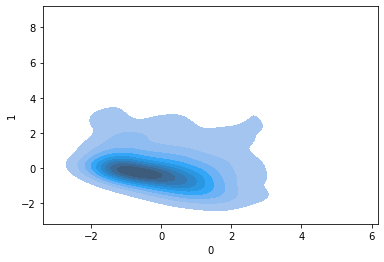

In [36]:
sns.kdeplot(data=Xp,x=0,y=1,fill=True)

<AxesSubplot:xlabel='0', ylabel='1'>

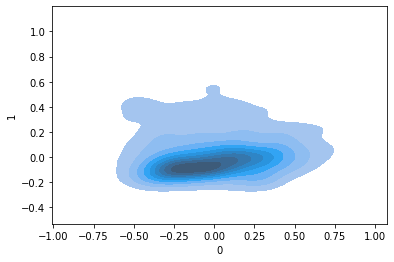

In [37]:
sns.kdeplot(data=Xm,x=0,y=1,fill=True)

<AxesSubplot:xlabel='0', ylabel='1'>

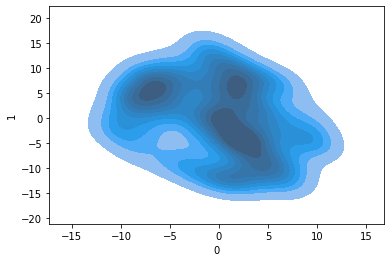

In [38]:
sns.kdeplot(data=Xt,x=0,y=1,fill=True)

***

***
# <p style="text-align: center;">Clustering</p>



***

***

In [39]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=var_reduced)

## Aglomerativo 

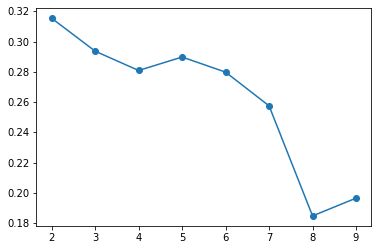

In [40]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              AgglomerativeClustering(n_clusters=k).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [41]:
k = 3
tipo = 'agg'
agg = AgglomerativeClustering(n_clusters=k)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =agg.fit_predict(Xs[var_reduced])

## K-medias

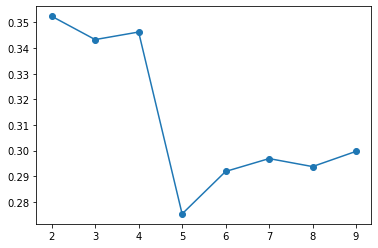

In [42]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              KMeans(n_clusters=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [43]:
k = 4
tipo = 'kme'
kme = KMeans(n_clusters=k,max_iter=1000)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =kme.fit_predict(Xs[var_reduced])

## Modelos Gaussianos Mixtos

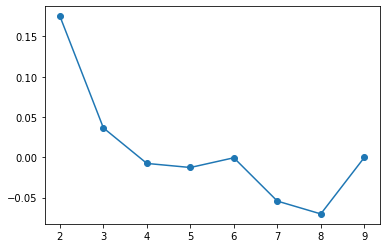

In [44]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              GaussianMixture(n_components=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [45]:
k = 3
tipo = 'gmm'
gmm = GaussianMixture(n_components=k,max_iter=1000)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =gmm.fit_predict(Xs[var_reduced])

## Selección final

In [46]:
varcl = sorted(df_sample.filter(like='cl_'))
for v in varcl:
    Xp[v] = Xp[v].astype(str)
    Xm[v] = Xm[v].astype(str)
    Xt[v] = Xt[v].astype(str)
    df_sample[v] = df_sample[v].astype(str)
    
pd.DataFrame(map(lambda cl:(cl,silhouette_score(Xs,df_sample[cl])),varcl),columns=['cluster','sil']).iplot(kind='bar',categories='cluster')

## Visualización con cluster

<AxesSubplot:xlabel='0', ylabel='1'>

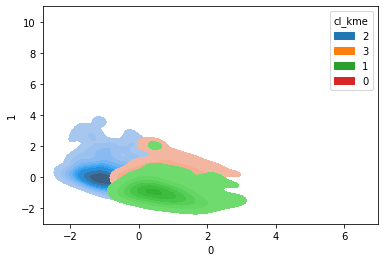

In [47]:
Xp.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xp,x=0,y=1,fill=True,hue='cl_kme')

<AxesSubplot:xlabel='0', ylabel='1'>

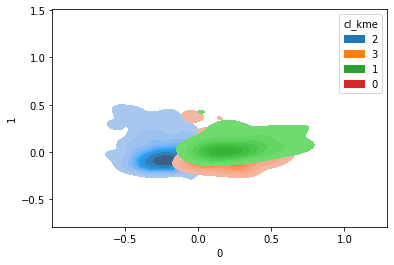

In [48]:
Xm.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xm,x=0,y=1,fill=True,hue='cl_kme')

<AxesSubplot:xlabel='0', ylabel='1'>

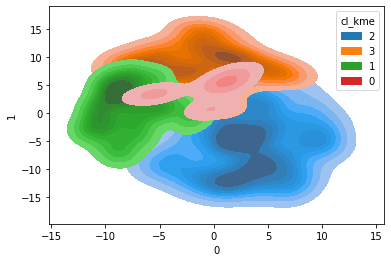

In [49]:
Xt.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xt,x=0,y=1,fill=True,hue='cl_kme')

## Perfilamiento

### Continuo

na_sales


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-0.6299,0.001,-0.839,-0.4209,True
0,2,-0.555,0.001,-0.7534,-0.3566,True
0,3,-0.6541,0.001,-0.8588,-0.4493,True
1,2,0.0749,0.211,-0.0243,0.1742,False
1,3,-0.0242,0.9,-0.1356,0.0873,False
2,3,-0.0991,0.0241,-0.189,-0.0092,True


user_count


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-1191.7454,0.001,-1258.1719,-1125.319,True
0,2,-1192.7971,0.001,-1255.837,-1129.7572,True
0,3,-1123.1746,0.001,-1188.244,-1058.1053,True
1,2,-1.0516,0.9,-32.5899,30.4866,False
1,3,68.5708,0.001,33.1496,103.992,True
2,3,69.6224,0.001,41.053,98.1919,True


user_score


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-1.9853,0.001,-2.3689,-1.6017,True
0,2,0.6941,0.001,0.3301,1.0581,True
0,3,0.0581,0.9,-0.3177,0.4338,False
1,2,2.6794,0.001,2.4973,2.8616,True
1,3,2.0434,0.001,1.8389,2.248,True
2,3,-0.636,0.001,-0.801,-0.4711,True


year_of_release


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-3.2683,0.001,-4.4106,-2.1259,True
0,2,-7.375,0.001,-8.4591,-6.2909,True
0,3,0.2253,0.9,-0.8936,1.3443,False
1,2,-4.1068,0.001,-4.6491,-3.5644,True
1,3,3.4936,0.001,2.8845,4.1027,True
2,3,7.6004,0.001,7.1091,8.0917,True


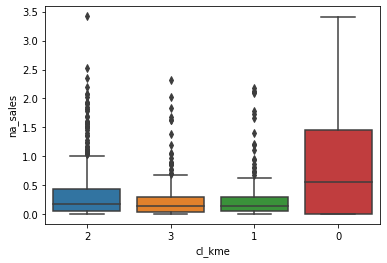

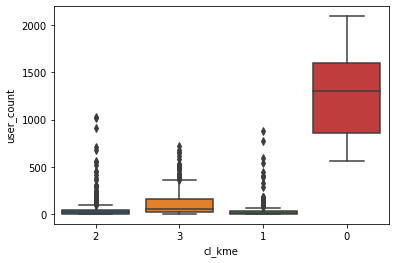

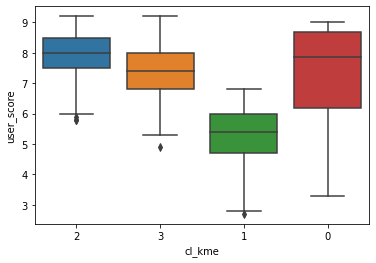

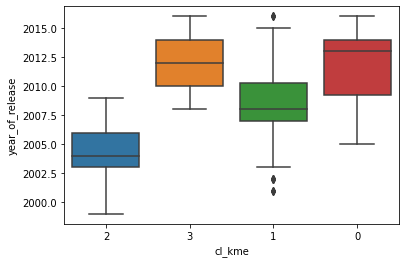

In [50]:
for v in var_reduced:
    print(v)
    display(MultiComparison(df_sample[v],df_sample['cl_kme']).tukeyhsd().summary())
    plt.figure()
    sns.boxplot(data=df_sample,y=v,x='cl_kme')

### Discreto

In [51]:
for v in varn:
    piv = df_sample.pivot_table(index='cl_kme',
                     columns=v,
                     values='user_score',
                     aggfunc='count',
                     fill_value=0)
    observadas = [[np.round(x/sum(l)*100,0) for x in l] for l in piv.values]

    esperada = list(np.round((df[v].value_counts().sort_index()/len(df)*100),0))

    display(pd.DataFrame(enumerate(map(lambda obs:np.round(chisquare(f_exp=esperada,
                                                                     f_obs=obs).pvalue,4),observadas)),columns=['cluster','p-value']).assign(variable=v))

    piv['t'] = piv.sum(axis=1)
    for c in piv.columns:
        if c!='t':
            piv[c]/=piv['t']

    piv.drop('t',axis=1,inplace=True)

    esp = pd.DataFrame({'total':esperada}).T
    esp.columns = piv.columns

    pd.concat([piv.apply(lambda x:np.round(x*100,0)),esp]).iplot(kind='bar',barmode='stack')

,cluster,p-value,variable
0,0,0.0000,n_platform
1,1,0.0000,n_platform
2,2,0.0001,n_platform
3,3,0.0000,n_platform


,cluster,p-value,variable
0,0,0.0000,n_genre
1,1,0.3325,n_genre
2,2,0.8331,n_genre
3,3,0.2733,n_genre


,cluster,p-value,variable
0,0,0.2644,n_publisher
1,1,0.6349,n_publisher
2,2,0.9489,n_publisher
3,3,0.3797,n_publisher


,cluster,p-value,variable
0,0,0.0000,n_rating
1,1,0.3927,n_rating
2,2,0.4783,n_rating
3,3,0.0912,n_rating


## Arquetipos

In [52]:
display(df_sample[var_reduced+['cl_kme']].groupby('cl_kme').mean())
display(df_sample[var_reduced].mean().to_frame().T)

,na_sales,user_count,user_score,year_of_release
cl_kme,,,,
0,0.900263,1245.684211,7.271053,2011.763158
1,0.270357,53.938776,5.285714,2008.494898
2,0.345287,52.887129,7.965149,2004.388119
3,0.246207,122.509579,7.329119,2011.988506


,na_sales,user_count,user_score,year_of_release
0,0.32583,116.591,7.2476,2007.457


## Gráfico Radial

In [53]:
Xs['cl_kme'] = df_sample['cl_kme']

In [54]:
aux = Xs[var_reduced+['cl_kme']].groupby('cl_kme').mean()
aux

,na_sales,user_count,user_score,year_of_release
cl_kme,,,,
0,0.263235,0.595532,0.703239,0.750774
1,0.079052,0.023951,0.397802,0.558523
2,0.100961,0.023447,0.810023,0.316948
3,0.071990,0.056839,0.712172,0.764030


In [55]:
fig = go.Figure()

for i,row in aux.iterrows():
    fig.add_trace(go.Scatterpolar(r=row.values,
                                  theta=var_reduced,
                                  fill='toself',
                                  name=f'cluster {i}'))
fig.show()

***

***
# <p style="text-align: center;">Clustering excluyendo la variable de Año</p>



***

***

In [56]:
var_reduced = var_reduced[:-1]
var_reduced

['na_sales', 'user_count', 'user_score']

### Aglomerativo 

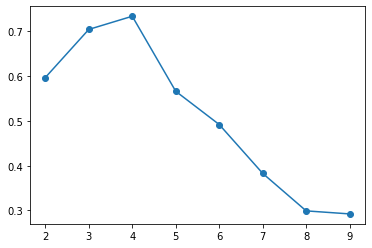

In [57]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              AgglomerativeClustering(n_clusters=k).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [58]:
k = 4
tipo = 'agg'
agg = AgglomerativeClustering(n_clusters=k)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =agg.fit_predict(Xs[var_reduced])

### K-medias

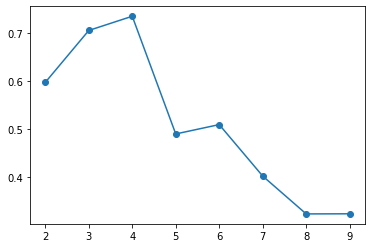

In [59]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              KMeans(n_clusters=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [60]:
k = 4
tipo = 'kme'
kme = KMeans(n_clusters=k,max_iter=1000)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =kme.fit_predict(Xs[var_reduced])

### Modelos Gaussianos Mixtos

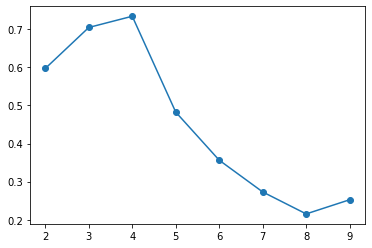

In [61]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              GaussianMixture(n_components=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [62]:
k = 4
tipo = 'gmm'
gmm = GaussianMixture(n_components=k,max_iter=1000)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =gmm.fit_predict(Xs[var_reduced])

### Selección final

In [63]:
varcl = sorted(df_sample.filter(like='cl_'))
for v in varcl:
    Xp[v] = Xp[v].astype(str)
    Xm[v] = Xm[v].astype(str)
    Xt[v] = Xt[v].astype(str)
    df_sample[v] = df_sample[v].astype(str)
    
pd.DataFrame(map(lambda cl:(cl,silhouette_score(Xs,df_sample[cl])),varcl),columns=['cluster','sil']).iplot(kind='bar',categories='cluster')

## Gráfico Radial

In [64]:
Xs['cl_agg'] = df_sample['cl_agg']

In [65]:
aux = Xs[var_reduced+['cl_agg']].groupby('cl_agg').mean()
aux

,na_sales,user_count,user_score
cl_agg,,,
0,0.070674,0.027614,0.793755
1,0.064584,0.034079,0.419118
2,0.099334,0.559153,0.720085
3,0.571111,0.141736,0.755077


In [66]:
fig = go.Figure()

for i,row in aux.iterrows():
    fig.add_trace(go.Scatterpolar(r=row.values,
                                  theta=var_reduced,
                                  fill='toself',
                                  name=f'cluster {i}'))
fig.show()

In [67]:
display(df_sample[var_reduced+['cl_kme']].groupby('cl_kme').mean())
display(df_sample[var_reduced].mean().to_frame().T)

,na_sales,user_count,user_score
cl_kme,,,
0,0.625312,1308.468750,7.846875
1,0.202615,63.835526,7.935691
2,1.560769,168.435897,7.739744
3,0.215922,80.744681,5.559929


,na_sales,user_count,user_score
0,0.32583,116.591,7.2476
